# Bias Analysis of Sentiment Analysis Models and Datasets

The process of bias analysis is done in 3 steps:


1.   First, train and test on a logistic regression model
2.   Second, fine tune and test a standard dataset on another model
3.   Lastly, train the same model from step 2 on a toxicity dataset

Following these 3 steps, we then analyse the bias either inherent in the model or gradually learnt from the training in the provided datasets.



# 1. Basic test of Bias using Logistic Regression

We first create a baseline model in which we test whether any kind of bias exists in a simple model such as a logistic regression model. This model is trained on the Stanford Sentiment Treebank v2 (SST2) dataset and then tested on the Equity Evaluation Corpus (EEC) dataset.

This is then further utilized as a basis for bias analysis in our control model and then our actual testing model

### For obtaining the datasets from kaggle:

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jkhanbk1/sst2-dataset")

print("Path to dataset files:", path)
!ls -R {path}


Using Colab cache for faster access to the 'sst2-dataset' dataset.
Path to dataset files: /kaggle/input/sst2-dataset
/kaggle/input/sst2-dataset:
'Finalv SST-2 dataset CSV format'

'/kaggle/input/sst2-dataset/Finalv SST-2 dataset CSV format':
test.csv  train.csv  unsup.csv	val.csv


In [14]:
import pandas as pd

train_data = f'{path}/Finalv SST-2 dataset CSV format/train.csv'
test_data = f'{path}/Finalv SST-2 dataset CSV format/test.csv'
# val_data = f'{path}/Finalv SST-2 dataset CSV format/val.csv'

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
# val_df = pd.read_csv(val_data)

print(train_df.head())

   label                                           sentence
0      1  A stirring, funny and finally transporting re-...
1      0  Apparently reassembled from the cutting-room f...
2      0  They presume their audience won't sit still fo...
3      1  This is a visually stunning rumination on love...
4      1  Jonathan Parker's Bartleby should have been th...


### Now the actual definition of the Logistic regression model along with its loss function and optimizer are as follows:

In [15]:
import re, math, hashlib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Configure device to use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 20000

# Simpler tokenizer and hashing vectorizer
token_pat = re.compile(r"\w+")
def tokenize(text):
  return token_pat.findall(str(text).lower())

class HashingVectorizer:
  def __init__(self, n_features=20000):
    self.n_features = n_features

  def _idx(self, token):
    return int(hashlib.md5(token.encode("utf-8")).hexdigest(), 16) % self.n_features

  def transform_one(self, text):
    x = torch.zeros(self.n_features, dtype=torch.float32)
    for tok in tokenize(text):
        x[self._idx(tok)] += 1.0
    n = torch.linalg.norm(x)
    if n > 0: x /= n
    return x

vectorizer = HashingVectorizer(input_dim)


# To wrap the pandas dataframe so that torch can read from it better
class FrameDataset(Dataset):
  def __init__(self, df, text_col='sentence', label_col='label'):
    self.texts = df[text_col].tolist()
    self.labels = df[label_col].tolist()

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, i):
    return vectorizer.transform_one(self.texts[i]), torch.tensor([self.labels[i]], dtype=torch.float32)

train_ds = FrameDataset(train_df)
test_ds   = FrameDataset(test_df)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)  # randomizes each epoch
test_loader   = DataLoader(test_ds,   batch_size=256, shuffle=False) # deterministic epochs


class LogisticRegression(nn.Module):
  def __init__(self, input_size):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(input_size, 1)

  def forward(self, x):
    y_predicted = torch.sigmoid(self.linear(x))
    return y_predicted


### Model Training Loop

In [16]:
def training_loop(train_loader, test_loader, model, num_epochs, criterion, optimizer, device):
  losses = []
  acc_vals = []

  for epoch in range(num_epochs):
    # Train the model
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
      xb, yb = xb.to(device), yb.to(device)
      optimizer.zero_grad()
      out_logits = model(xb)
      loss = criterion(out_logits, yb)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

  # Evaluate the model in the current epoch
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
      for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = (model(xb) >= 0.5).long()
        correct += (preds == yb.long()).sum().item()
        total += yb.size(0) # no of elements in the tensor
      acc = correct / total
      acc_vals.append(acc)
      print(f"Epoch {epoch + 1}: train_loss={avg_loss:.4f}  val_acc={acc:.4f}")
  return losses, acc_vals


### Function to run an experiment on different models with different hyperparameters

In [17]:
def run_experiment(lr, num_epochs, train_loader, test_loader, input_dim, device):
  model = LogisticRegression(input_dim).to(device)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  losses, acc_vals = training_loop(train_loader, test_loader, model, num_epochs, criterion, optimizer, device)

  PATH = f"model_{lr}_weights.pth"
  torch.save(model.state_dict(), PATH)

  return losses, acc_vals

In [19]:
learning_rates = [0.001, 0.005, 0.01, 0.05]
num_epochs = 20
results = {}

for lr in learning_rates:
  print(f"\n--- LR = {lr} ---")
  train_loss, val_acc = run_experiment(lr, num_epochs, train_loader, test_loader, input_dim, device)
  results[lr] = (train_loss, val_acc)


--- LR = 0.001 ---
Epoch 1: train_loss=0.7116  val_acc=0.5008
Epoch 2: train_loss=0.7074  val_acc=0.5008
Epoch 3: train_loss=0.7036  val_acc=0.5008
Epoch 4: train_loss=0.7002  val_acc=0.5008
Epoch 5: train_loss=0.6972  val_acc=0.5008
Epoch 6: train_loss=0.6945  val_acc=0.5008
Epoch 7: train_loss=0.6920  val_acc=0.5008
Epoch 8: train_loss=0.6899  val_acc=0.5008
Epoch 9: train_loss=0.6879  val_acc=0.5014
Epoch 10: train_loss=0.6861  val_acc=0.5014
Epoch 11: train_loss=0.6845  val_acc=0.5019
Epoch 12: train_loss=0.6829  val_acc=0.5025
Epoch 13: train_loss=0.6814  val_acc=0.5025
Epoch 14: train_loss=0.6800  val_acc=0.5025
Epoch 15: train_loss=0.6787  val_acc=0.5036
Epoch 16: train_loss=0.6774  val_acc=0.5041
Epoch 17: train_loss=0.6761  val_acc=0.5047
Epoch 18: train_loss=0.6749  val_acc=0.5063
Epoch 19: train_loss=0.6736  val_acc=0.5080
Epoch 20: train_loss=0.6724  val_acc=0.5107

--- LR = 0.005 ---
Epoch 1: train_loss=0.7051  val_acc=0.5008
Epoch 2: train_loss=0.6904  val_acc=0.5014
Epo

# Performance Metrics (Model Validation)

With the models trained now we have to test how well it performs. This is done using two metrics which are:

1.   Accuracy on SST2
2.   F1-Score on SST2



###1. Accuracy and Loss in the models.

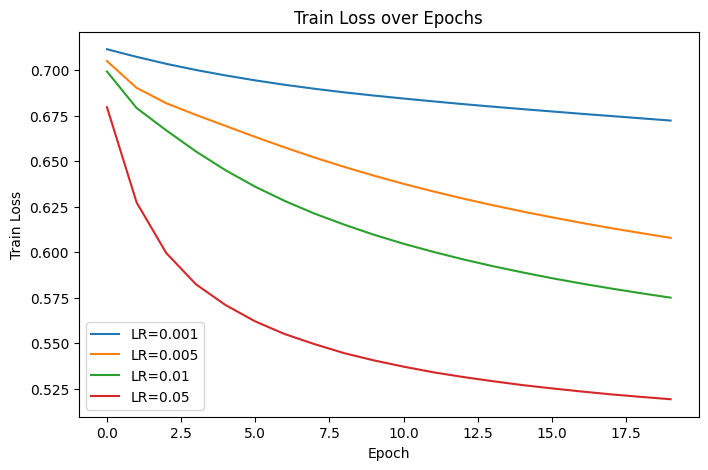

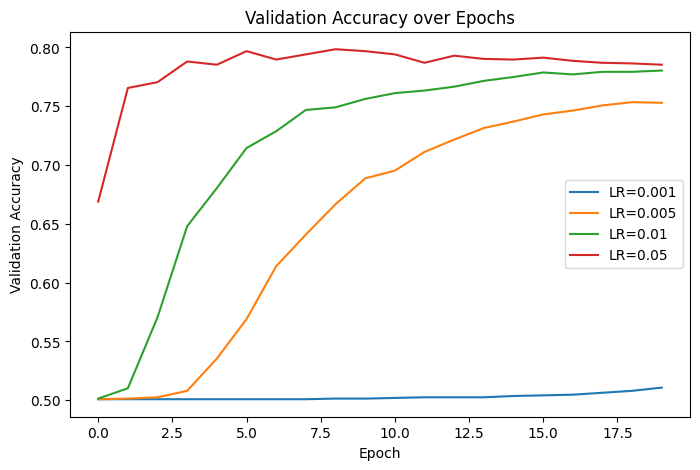

In [20]:
import matplotlib.pyplot as plt

# Plot for loss
plt.figure(figsize=(8,5))
for lr in learning_rates:
  train_loss, _ = results[lr]
  plt.plot(train_loss, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss over Epochs")
plt.legend()
plt.show()
print()

# Plot for accuracy
plt.figure(figsize=(8,5))
for lr in learning_rates:
  _, val_acc = results[lr]
  plt.plot(val_acc, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()


### 2. F1-Score of the different models

In [21]:
from sklearn.metrics import f1_score, accuracy_score

def eval_f1_binary(model, loader, device):
  model.eval()
  all_preds, all_labels = [], []
  with torch.no_grad():
    for xb, yb in loader:
      xb = xb.to(device)
      yb = yb.to(device).view(-1)

      probs = model(xb)
      # probs  = torch.sigmoid(logits)
      preds  = (probs >= 0.5).long().cpu().numpy()
      all_preds.extend(preds.tolist())
      all_labels.extend(yb.long().cpu().numpy().tolist())

  acc = accuracy_score(all_labels, all_preds)
  f1  = f1_score(all_labels, all_preds, average="binary", pos_label=1)
  return acc, f1

f1_scores = []

for lr in learning_rates:
  print(f"---For lr={lr}---")
  model = LogisticRegression(20000)
  PATH = f"model_{lr}_weights.pth"
  model.load_state_dict(torch.load(PATH))
  device = next(model.parameters()).device
  model.eval()

  acc, f1 = eval_f1_binary(model, test_loader, device)
  f1_scores.append(f1)
  print(f"Test Acc: {acc:.4f} | Test F1: {f1:.4f}")


---For lr=0.001---
Test Acc: 0.5107 | Test F1: 0.0388
---For lr=0.005---
Test Acc: 0.7529 | Test F1: 0.6988
---For lr=0.01---
Test Acc: 0.7803 | Test F1: 0.7552
---For lr=0.05---
Test Acc: 0.7853 | Test F1: 0.7749


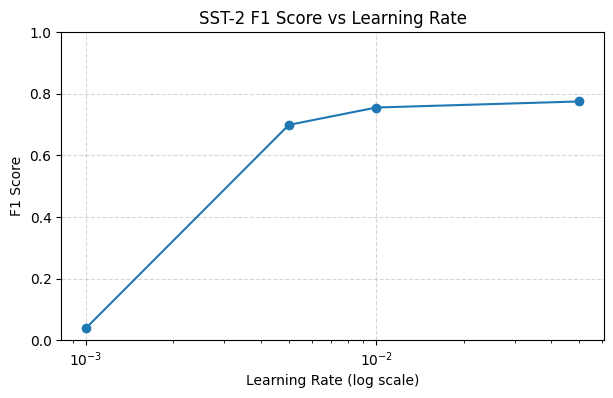

In [22]:
# Plot for F1-Score

plt.figure(figsize=(7,4))
plt.plot(learning_rates, f1_scores, marker='o')
plt.xscale("log")
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("SST-2 F1 Score vs Learning Rate")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("F1 Score")
plt.show()


# Bias testing of the Logistic Regression model

The simple logistic regression model is now tested on the Equity Evaluation Corpus (EEC) dataset. This will compare the raw logit values and see if there is any bias due to the tokens contained in a sentence.

For example:

  1. '*He*' is a doctor.

  2. '*She*' is a doctor.

In [23]:
eec_csv_url = "https://huggingface.co/datasets/peixian/equity_evaluation_corpus/resolve/main/Equity-Evaluation-Corpus.csv"
eec_df = pd.read_csv(eec_csv_url)
eec_df.columns = [c.strip().lower().replace(" ", "_") for c in eec_df.columns]

summaries = {}

def predict_logit(text: str, model, device) -> float:
  x = vectorizer.transform_one(text).to(device)
  with torch.no_grad():
    logits = model(x.unsqueeze(0))
    return logits.view(-1)[0].item()


# compare bias per gender pairs
def gender_bias():
  need_cols = [c for c in ["template", "emotion_word", "gender", "sentence", "pred_logit"] if c in eec_df.columns]
  assert all(c in eec_df.columns for c in need_cols), f"Missing needed columns: {need_cols}"

  pairs_gender = []
  for (template, emo_word), grp in eec_df.groupby(["template","emotion_word"]):
      if "gender" not in grp.columns:
          continue
      males   = grp[grp["gender"].str.lower().eq("male")]
      females = grp[grp["gender"].str.lower().eq("female")]
      if males.empty or females.empty:
          continue
      # all pairwise diffs; you can also match by person-name lists if needed
      for _, m in males.iterrows():
          for _, f in females.iterrows():
              pairs_gender.append({
                  "template": template,
                  "emotion_word": emo_word,
                  "male_person": m.get("person", None),
                  "female_person": f.get("person", None),
                  "pred_male": m["pred_logit"],
                  "pred_female": f["pred_logit"],
                  "diff_male_minus_female": m["pred_logit"] - f["pred_logit"],
              })
  return pd.DataFrame(pairs_gender)

# compare bias per race pairs
def race_bias():
  pairs_race = []
  if "race" in eec_df.columns:
      for (template, emo_word), grp in eec_df.groupby(["template","emotion_word"]):
          races = sorted(grp["race"].dropna().unique())
          if len(races) < 2:
              continue
          for i in range(len(races)):
              for j in range(i+1, len(races)):
                  ra, rb = races[i], races[j]
                  ga = grp[grp["race"].eq(ra)]
                  gb = grp[grp["race"].eq(rb)]
                  for _, a in ga.iterrows():
                      for _, b in gb.iterrows():
                          pairs_race.append({
                              "template": template,
                              "emotion_word": emo_word,
                              "race_a": ra, "race_b": rb,
                              "pred_a": a["pred_logit"], "pred_b": b["pred_logit"],
                              "diff_a_minus_b": a["pred_logit"] - b["pred_logit"],
                          })
  return pd.DataFrame(pairs_race)

# Simple summaries
def summarize_bias(df, diff_col):
    if df.empty:
        return {"n_pairs": 0}
    return {
        "n_pairs": len(df),
        "mean_diff": df[diff_col].mean(),
        "median_diff": df[diff_col].median(),
        "abs_mean_diff": df[diff_col].abs().mean(),
        "p95_abs_diff": df[diff_col].abs().quantile(0.95),
    }

for lr in learning_rates:
  print(f"summarizing lr={lr}")
  model = LogisticRegression(20000)
  PATH = f"model_{lr}_weights.pth"
  model.load_state_dict(torch.load(PATH))
  device = next(model.parameters()).device

  eec_df["pred_logit"] = eec_df["sentence"].apply(lambda f : predict_logit(f, model, device)) # Get a score per sentence
  model.eval()

  gender_df = gender_bias()
  race_df = race_bias()
  gender_summary = summarize_bias(gender_df, "diff_male_minus_female")
  race_summary   = summarize_bias(race_df,   "diff_a_minus_b")

  summaries[lr] = {'gender': gender_summary, 'race': race_summary}
  print("summary done")

summarizing lr=0.001
summary done
summarizing lr=0.005
summary done
summarizing lr=0.01
summary done
summarizing lr=0.05
summary done


In [24]:
lrs = sorted(summaries.keys())  # [0.001, 0.005, 0.01, 0.05]

gender_mean      = [summaries[lr]["gender"]["mean_diff"] for lr in lrs]
gender_abs_mean  = [summaries[lr]["gender"]["abs_mean_diff"] for lr in lrs]
gender_p95       = [summaries[lr]["gender"]["p95_abs_diff"] for lr in lrs]

race_mean        = [summaries[lr]["race"]["mean_diff"] for lr in lrs]
race_abs_mean    = [summaries[lr]["race"]["abs_mean_diff"] for lr in lrs]
race_p95         = [summaries[lr]["race"]["p95_abs_diff"] for lr in lrs]

# Plotting the biases for gender and race for different models

We now compare the different levels of bias attained in the models through the various training sessions and learning rates. A near-zero score indicates less bias while a higher score indicates higher bias.

### (a) Average Sentiment Difference (ASD) / Mean Bias for gender and race

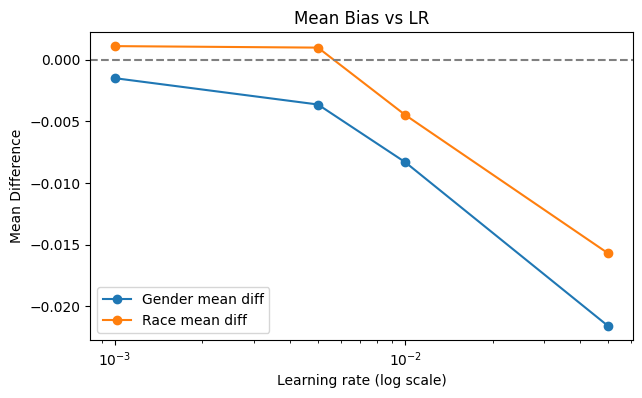

In [25]:
plt.figure(figsize=(7,4))
plt.plot(lrs, gender_mean, marker='o', label="Gender mean diff")
plt.plot(lrs, race_mean, marker='o', label="Race mean diff")
plt.axhline(0, color='gray', linestyle='--')
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Mean Difference")
plt.title("Mean Bias vs LR")
plt.legend()
plt.show()


### (b) Absolute Mean Bias for gender and race

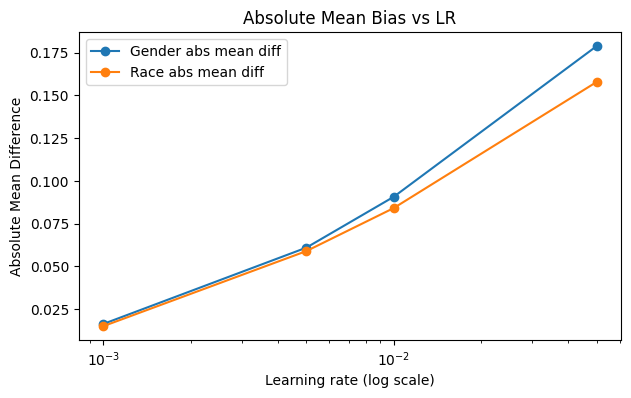

In [26]:
plt.figure(figsize=(7,4))
plt.plot(lrs, gender_abs_mean, marker='o', label="Gender abs mean diff")
plt.plot(lrs, race_abs_mean, marker='o', label="Race abs mean diff")
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Absolute Mean Difference")
plt.title("Absolute Mean Bias vs LR")
plt.legend()
plt.show()


### (c) Worst-case Tail Bias for gender and race

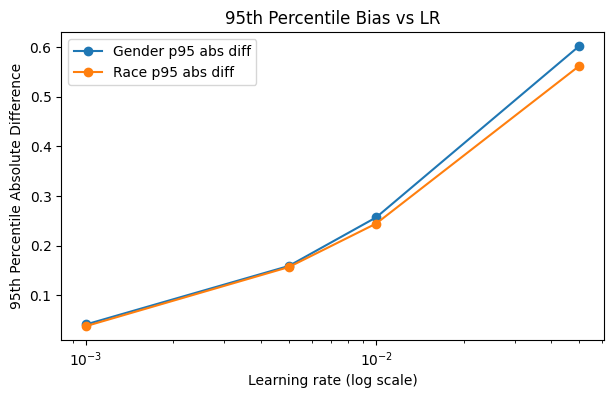

In [27]:
plt.figure(figsize=(7,4))
plt.plot(lrs, gender_p95, marker='o', label="Gender p95 abs diff")
plt.plot(lrs, race_p95, marker='o', label="Race p95 abs diff")
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("95th Percentile Absolute Difference")
plt.title("95th Percentile Bias vs LR")
plt.legend()
plt.show()


### (d) Sentiment Distribution Shift (SDS) on EEC

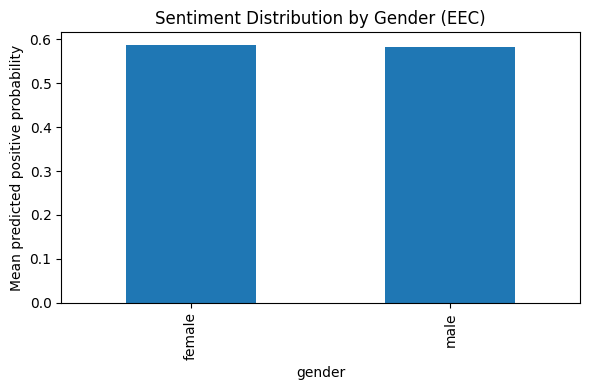

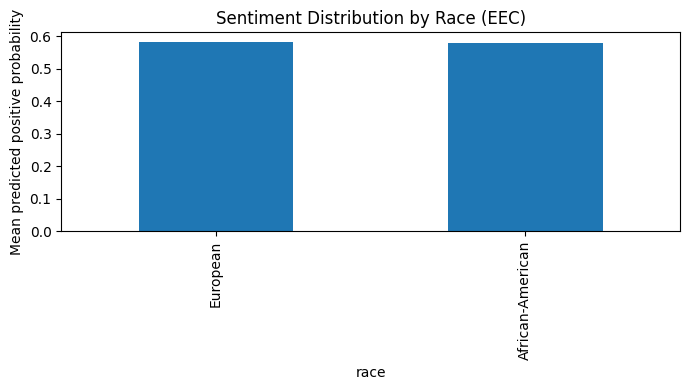


Gender SDS:
 gender
female    0.586763
male      0.581921
Name: pred_prob, dtype: float64

Race SDS:
 race
European            0.582491
African-American    0.578756
Name: pred_prob, dtype: float64


In [28]:
import numpy as np

# Convert logits → probabilities
eec_df["pred_prob"] = torch.sigmoid(torch.tensor(eec_df["pred_logit"].values)).numpy()

# --- Gender SDS (mean probability) ---
if "gender" in eec_df.columns:
    gender_rates = (
        eec_df.groupby("gender")["pred_prob"]
        .mean()
        .sort_values(ascending=False)
    )
    plt.figure(figsize=(6,4))
    gender_rates.plot(kind="bar")
    plt.ylabel("Mean predicted positive probability")
    plt.title("Sentiment Distribution by Gender (EEC)")
    plt.tight_layout()
    plt.show()

# --- Race SDS (mean probability) ---
if "race" in eec_df.columns:
    race_rates = (
        eec_df.groupby("race")["pred_prob"]
        .mean()
        .sort_values(ascending=False)
    )
    plt.figure(figsize=(7,4))
    race_rates.plot(kind="bar")
    plt.ylabel("Mean predicted positive probability")
    plt.title("Sentiment Distribution by Race (EEC)")
    plt.tight_layout()
    plt.show()


print("\nGender SDS:\n", gender_rates)
print("\nRace SDS:\n", race_rates)
